### Load and compile Crossformer model once

In [1]:
from crossformer.model.crossformer_model import CrossFormerModel

model = CrossFormerModel.load_pretrained("hf://rail-berkeley/crossformer")

2025-01-11 17:12:22.027595: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-11 17:12:22.027652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-11 17:12:22.045422: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 17:12:23.616266: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

2025-01-11 17:14:29.445450: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
text_goal = "pick up the banana"
task = model.create_tasks(texts=[text_goal])

In [4]:
# dummy inference
import jax
import numpy as np

WINDOW_SIZE = 5

img = np.random.randint(0, 255, size=(224, 224, 3))
input_images = img[None, None].repeat(WINDOW_SIZE, 1)
print(input_images.shape)

observation = {
    "image_primary": input_images,
    "timestep_pad_mask": np.full((1, input_images.shape[1]), True, dtype=bool),
}

actions = model.sample_actions(
        observation,
        task,
        head_name="single_arm",
        unnormalization_statistics=model.dataset_statistics["bridge_dataset"]["action"],
        rng=jax.random.PRNGKey(0),
)
actions = actions[0]  

print(actions.shape)

(1, 5, 224, 224, 3)
(4, 7)


### Start a Pybullet simulation

In [5]:
from environment.utilities import Camera, MultiCams
from environment.env import Environment
from utils import YcbObjects, PackPileData, IsolatedObjData, summarize
import pybullet as p
import numpy as np
import random

from yacs.config import CfgNode as CN

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import FancyBboxPatch
from pprint import pprint
import cv2

# helper function
%matplotlib inline
def display_image(path_or_array, size=(10, 10)):
  if isinstance(path_or_array, str):
    image = np.asarray(Image.open(open(image_path, 'rb')).convert("RGB"))
  else:
    image = path_or_array
  
  plt.figure(figsize=size)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

pybullet build time: Nov 28 2023 23:45:17


In [6]:
runs=1
CAM_Z = 1.9
IMG_SIZE = 224

seed = 429

In [7]:
    def dummy_simulation_steps(env,n):
        for _ in range(n):
            p.stepSimulation()

In [8]:
        objects = YcbObjects('objects/ycb_objects',
                            mod_orn=['ChipsCan', 'MustardBottle', 'TomatoSoupCan'],
                            mod_stiffness=['Strawberry'])
        objects.shuffle_objects()
        
        #data = IsolatedObjData(objects.obj_names, runs, 'results')

        center_x, center_y, center_z = 0.05, -0.52, CAM_Z
        camera = Camera((center_x, center_y, center_z), (center_x, center_y, 0.785), 0.2, 2.0, (IMG_SIZE, IMG_SIZE), 40, [0, 1, 0])
        # set seed to make sure the tomato soup can is always spawned at same place for development
        env = Environment(camera, vis=True, debug=False, finger_length=0.06, seed=seed)

In [9]:
env.reset_robot()          
env.remove_all_obj()
obj_name = "Banana"                        
               
path, mod_orn, mod_stiffness = objects.get_obj_info(obj_name)
env.load_isolated_obj(path, mod_orn, mod_stiffness)
dummy_simulation_steps(env, 20)

In [10]:
# get it to better starting position
env.move_gripper(0.085)
env.move_ee([0.1, -0.52, 1.3, (0.0003269339204036837, 0.7162828147217722, -0.0003361126858255739, 0.6978099379320486)])
dummy_simulation_steps(env, 20)

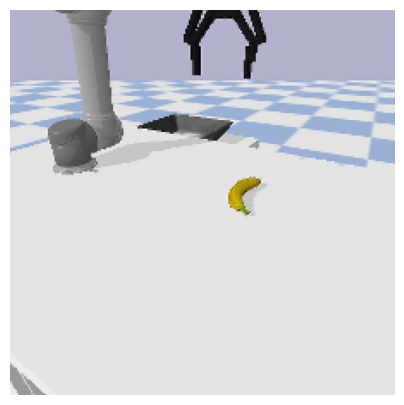

In [11]:
# you can use this shell to experiment with camera placement without having to reset simulation. After you find good config, you can copy paste to utilities.py
def get_cfg():
    _C1 = CN()
    _C1.FOCUS_PT = [0.0, -0.52, 0.785]
    _C1.YAW_ANGLES = [-60, 45, -45, 135]
    _C1.DISTANCES = [0.75, 0.8, 0.8, 0.8]
    _C1.PITCH_ANGLES = [-30, -25, -25, -25]
    return _C1.clone()
    
def render_tmp(env):
        
        def transform_image(image):
            h, w = image.shape[:2]
            # Center crop to 480x480
            start_x = w//2 - 240
            start_y = h//2 - 240
            image = image[start_y:start_y+480, start_x:start_x+480]
            #image = image[:,240:]
            # Resize to 224x224
            image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LANCZOS4)
            return image

        camera = MultiCams(env.physicsClient, cfg=get_cfg(), n_cams=1)
        rgb, _ = camera.cams[0].get_images(get_rgb=True, get_depth=False, get_seg=False)
        rgb_transformed = transform_image(rgb)
        return rgb_transformed

img = render_tmp(env)
display_image(img, (5,5))

### Test `TrajectoryGenerator` without resetting the Crossformer model

In [12]:
# run this cell to re-import TrajectoryGenerator if you make code changes, without having to restart the notebook
import importlib
import trajectory_generator
importlib.reload(trajectory_generator)
from trajectory_generator import TrajectoryGenerator

In [13]:
generator = TrajectoryGenerator(model, task, get_cfg(), 224, 500, 5, make_video=True)

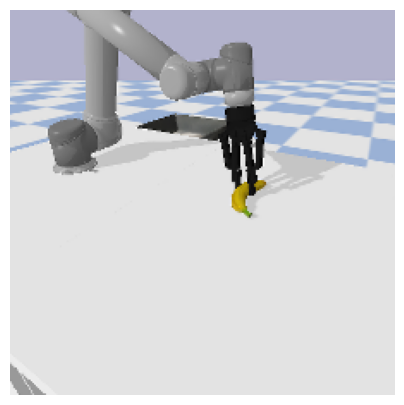

In [16]:
img = generator.render(env)
display_image(img, (5,5))

In [15]:
generator.predict_trajectory(env)

Action 1/4 in step 1/500.
Took delta action [ 0.00260414 -0.00660466 -0.00784212 -0.01018332  0.00460246 -0.09384034
  0.9960673 ]


Action 2/4 in step 1/500.
Took delta action [ 0.00318227 -0.00676599 -0.00891372 -0.00856818  0.00445216 -0.11231297
  0.99647695]


Action 3/4 in step 1/500.
Took delta action [ 0.00312344 -0.0058684  -0.00896232 -0.0063875   0.00394057 -0.11618824
  0.99629146]


Action 4/4 in step 1/500.
Took delta action [ 0.00250792 -0.00441754 -0.00836701 -0.00477898  0.00388466 -0.10078169
  0.9953983 ]


Action 1/4 in step 2/500.
Took delta action [ 5.45586599e-03 -1.03248740e-02 -1.08324895e-02 -8.50853219e-04
  2.06452515e-03 -3.00818048e-02  9.99266803e-01]


Action 2/4 in step 2/500.
Took delta action [ 5.5425507e-03 -1.1165823e-02 -1.0783756e-02 -1.1326369e-04
  1.9333940e-03 -2.2047548e-02  9.9915707e-01]


Action 3/4 in step 2/500.
Took delta action [ 4.8318314e-03 -1.0380376e-02 -1.0197227e-02  2.8162100e-04
  1.8070572e-03 -1.4408477e-02  9.9913061e-01]



In [85]:
p.disconnect()

In [17]:
# Function to append frames to a video and save the result
def append_frames_to_video(input_file, output_file, extra_frames, fps=None):
    # Open the input video
    video_capture = cv2.VideoCapture(input_file)
    if not video_capture.isOpened():
        raise ValueError(f"Unable to open video file: {input_file}")

    # Get properties of the input video
    original_fps = fps or int(video_capture.get(cv2.CAP_PROP_FPS))
    width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    # Create the VideoWriter object for the output video
    out = cv2.VideoWriter(output_file, fourcc, original_fps, (width, height))

    # Write the original frames to the output video
    while True:
        ret, frame = video_capture.read()
        if not ret:
            break
        out.write(frame)

    # Validate dimensions of extra frames
    for frame in extra_frames:
        if frame.shape[1] != width or frame.shape[0] != height:
            raise ValueError("All appended frames must have the same dimensions as the original video.")

    # Write the extra frames to the output video
    for frame in extra_frames:
        out.write(frame)

    # Release resources
    video_capture.release()
    out.release()
    print(f"Video saved as {output_file}")

In [ ]:
append_frames_to_video('temp_video.mp4', 'temp_video1.mp4', [img]*4, fps=20)